In [121]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import functools
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
from datetime import timedelta
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
import pickle
import time
import json
from statistics import median

UNKNOWN = '<UNK>'
PADDING = '<PAD>'
CATEGORIE_ID = {'entailment' : 0, 'neutral' : 1, 'contradiction' : 2}

In [122]:
# load vocabulary
def load_vocab(vocabPath, threshold = 0):
    """
    :param vocabPath: path of vocabulary file
    :param threshold: mininum occurence of vocabulary, if a word occurence less than threshold, discard it
    :return: vocab: vocabulary dict {word : index}
    """
    vocab = {}
    index = 2
    vocab[PADDING] = 0
    vocab[UNKNOWN] = 1
    with open(vocabPath, encoding='utf-8') as f:
        for line in f:
            items = [v.strip() for v in line.split('||')]
            if len(items) != 2:
                print('Wrong format: ', line)
                continue
            if items[0]!= "":
                word, freq = items[0], int(items[1])
                if freq >= threshold:
                    vocab[word] = index
                    index += 1
    return vocab

In [123]:
def dataStats(dataPath):
    with open(dataPath, mode='r', encoding='utf-8') as f:
        s1LenList = []
        s2LenList = []
        diffLenList = []
        for line in f:
            l, s1, s2 = [v.strip() for v in line.strip().split('||')]
            s1, s2 = s1.lower(), s2.lower()
            s1Len = len(s1.split())
            s2Len = len(s2.split())
            diffInLen = abs(s1Len-s2Len)
            
            if diffInLen > 10:
                if s1Len > s2Len:
                    reconstructionLen = s2Len
                    
            
            s1LenList.append(s1Len)
            s2LenList.append(s2Len)
            diffLenList.append(diffInLen)
            
        fig, ax = plt.subplots(1,3,figsize=(20,10))
        bins1 = int((max(s1LenList)-min(s1LenList))/5)
        bins2 = int((max(s2LenList)-min(s2LenList))/5)
        bins3 = int((max(diffLenList)-min(diffLenList))/5)
        ax[0].hist(np.asarray(s1LenList),bins1)
        ax[0].set_title('Lenght of Evidence')
        ax[1].hist(np.asarray(s1LenList),bins2)
        ax[1].set_title('Lenght of Hypothesis')
        ax[2].hist(np.asarray(s1LenList),bins3)
        ax[2].set_title('Difference in lenght')
        plt.show()
        
        return s1LenList,s2LenList,diffLenList
            

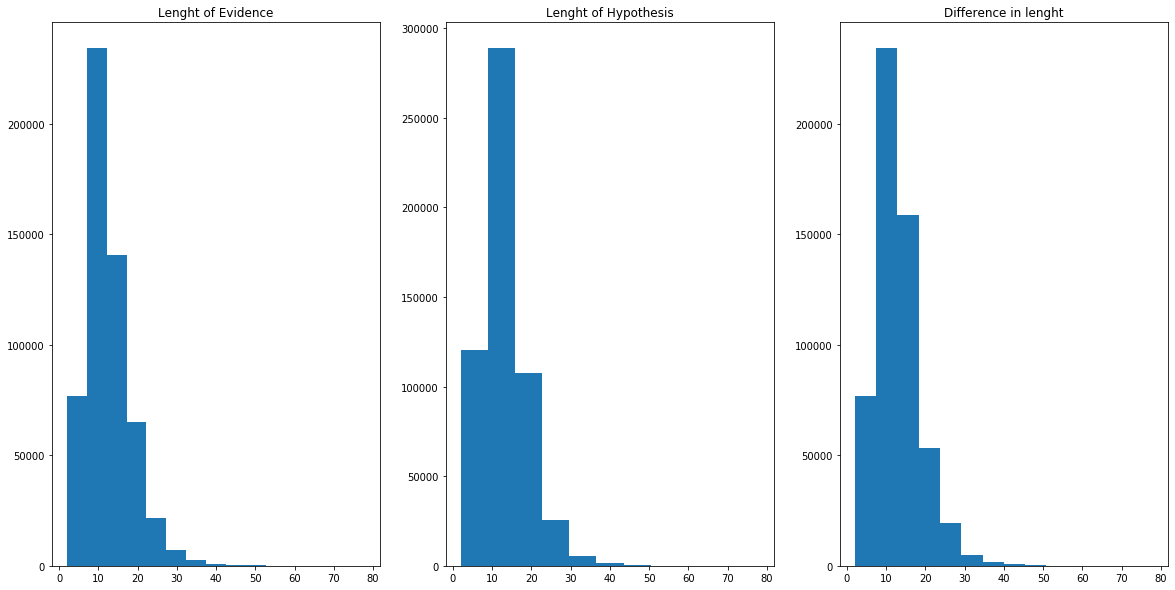

Median of difference: 15.0


In [124]:
s1LenList_,s2LenList_,diffLenList_=dataStats("./data/clean_data/train.txt")
print("Median of difference:",median(diffLenList))

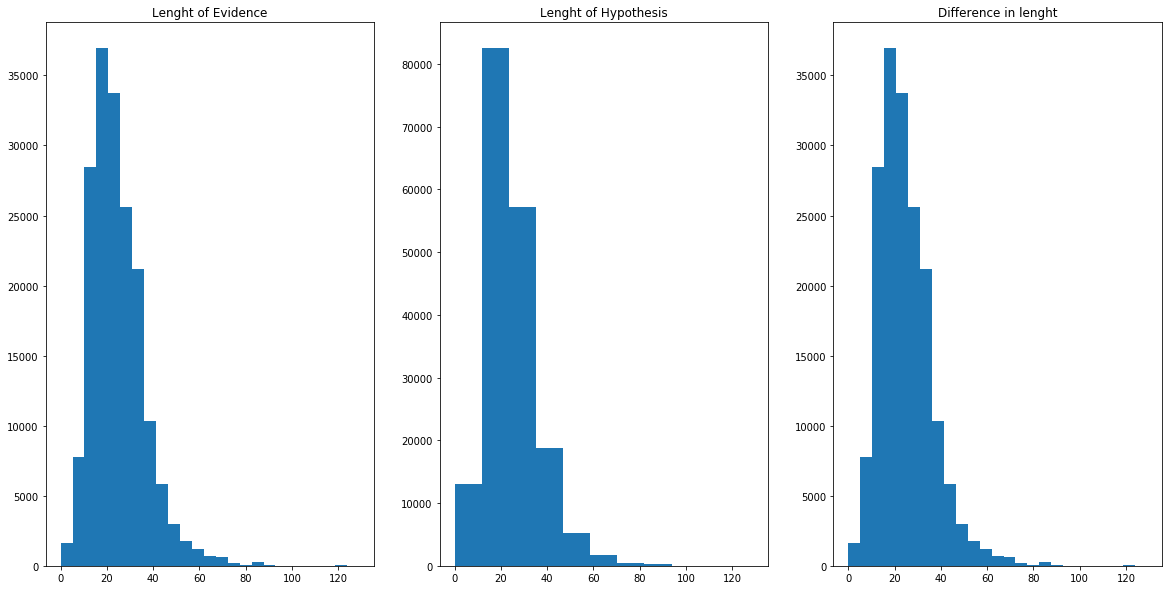

Median of difference: 15.0


In [125]:
s1LenList,s2LenList,diffLenList=dataStats("./data/clean_data/train_fever.txt")
print("Median of difference:",median(diffLenList))

In [149]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [151]:
a = chunks("this is supposed to work wtf. piece of shit code".split(),6)
for b in a:
    print (b)

['this', 'is', 'supposed', 'to', 'work', 'wtf.']
['piece', 'of', 'shit', 'code']


In [155]:
def sentence2Index(dataPath, vocabDict, maxLen = 100, lowercase = True):
    """
    :param dataPath: path of data filea
    :param vocabDict: vocabulary dict {word : index}
    :param maxLen: max length of sentence, if a sentence longer than maxLen, cut off it
    :param lowercase: boolean, lower words or not
    :return: s1Pad: padded sentence1
             s2Pad: padded sentence2
             s1Mask: actual length of sentence1
             s2Mask: actual length of sentence2
    """
    s1List, s2List, labelList = [], [], []
    s1Mask, s2Mask = [], []
    with open(dataPath, mode='r', encoding='utf-8') as f:
        c1,c2,c3=0,0,0
        for line in f:
            try:
                l, s1, s2 = [v.strip() for v in line.strip().split('||')]
                if lowercase:
                    s1, s2 = s1.lower(), s2.lower()
                s1 = [v.strip() for v in s1.split()]
                s2 = [v.strip() for v in s2.split()]
                
                if len(s1) > maxLen:
                    s1 = s1[:maxLen]
                if len(s2) > maxLen:
                    s2 = s2[:maxLen]
                    
                
                if len(s2)-len(s1) > 10 :
                    c1+=1
                    s2Chunks = chunks(s2,len(s1))
                    for s in s2Chunks:
                        #print("Did this happen")
                        if l in CATEGORIE_ID:
                            labelList.append([CATEGORIE_ID[l]])
                            s1List.append([vocabDict[word] if word in vocabDict else vocabDict[UNKNOWN] for word in s1])
                            s2List.append([vocabDict[word] if word in vocabDict else vocabDict[UNKNOWN] for word in s])
                            s1Mask.append(len(s1))
                            s2Mask.append(len(s))
                            
                elif len(s1)-len(s2) > 10:
                    c2+=1
                    s1Chunks = chunks(s1,len(s2))
                    for s in s1Chunks:
                        if l in CATEGORIE_ID:
                            labelList.append([CATEGORIE_ID[l]])
                            s1List.append([vocabDict[word] if word in vocabDict else vocabDict[UNKNOWN] for word in s])
                            s2List.append([vocabDict[word] if word in vocabDict else vocabDict[UNKNOWN] for word in s2])
                            s1Mask.append(len(s1))
                            s2Mask.append(len(s2))
                else:
                    c3+=1
                    if l in CATEGORIE_ID:
                        labelList.append([CATEGORIE_ID[l]])
                        s1List.append([vocabDict[word] if word in vocabDict else vocabDict[UNKNOWN] for word in s1])
                        s2List.append([vocabDict[word] if word in vocabDict else vocabDict[UNKNOWN] for word in s2])
                        s1Mask.append(len(s1))
                        s2Mask.append(len(s2))
            except:
                ValueError('Input Data Value Error!')
    print(c1,c2,c3)
    s1Pad, s2Pad = pad_sequences(s1List, maxLen, padding='post'), pad_sequences(s2List, maxLen, padding='post')
    s1MaskList, s2MaskList = (s1Pad > 0).astype(np.int32), (s2Pad > 0).astype(np.int32)
    enc = OneHotEncoder(sparse=False)
    labelList = enc.fit_transform(labelList)
    s1Mask = np.asarray(s1MaskList, np.int32)
    s2Mask = np.asarray(s2MaskList, np.int32)
    labelList = np.asarray(labelList, np.int32)
    return s1Pad, s1Mask, s2Pad, s2Mask, labelList

In [158]:
vocab_dict = load_vocab("data/clean_data/vocab.txt")
premise_train, premise_mask_train, hypothesis_train, hypothesis_mask_train, y_train = sentence2Index("data/clean_data/train.txt" ,vocab_dict)

417 91264 458471


In [159]:
print("Premise shape:",premise_train.shape)
print("Premise mask shape:",premise_mask_train.shape)
print("Hyp shape:",hypothesis_train.shape)
print("Hyp mask shape:",hypothesis_mask_train.shape)
print("y_train:",y_train.shape)

Premise shape: (832864, 100)
Premise mask shape: (832864, 100)
Hyp shape: (832864, 100)
Hyp mask shape: (832864, 100)
y_train: (832864, 3)


In [31]:
# init embeddings randomly
def init_embeddings(vocab, embedding_dims):
    """
    :param vocab: word nums of the vocabulary
    :param embedding_dims: dimension of embedding vector
    :return: randomly init embeddings with shape (vocab, embedding_dims)
    """
    rng = np.random.RandomState(None)
    random_init_embeddings = rng.normal(size = (len(vocab), embedding_dims))
    return random_init_embeddings.astype(np.float32)

# load pre-trained embeddings
def load_embeddings(path, vocab):
    """
    :param path: path of the pre-trained embeddings file
    :param vocab: word nums of the vocabulary
    :return: pre-trained embeddings with shape (vocab, embedding_dims)
    """
    present = 0
    absent = 0
    with open(path, 'rb') as fin:
        _embeddings, _vocab = pickle.load(fin)
    embedding_dims = _embeddings.shape[1]
    embeddings = init_embeddings(vocab, embedding_dims)
    for word, id in vocab.items():
        if word in _vocab:
            present+=1
            embeddings[id] = _embeddings[_vocab[word]]
        else:
            absent+=1
    print(present,absent)
    #return embeddings.astype(np.float32)

In [37]:
load_embeddings('data/embeddings.pkl',vocab_dict)

35013 13892


In [14]:
def next_batch(premise, premise_mask, hypothesis, hypothesis_mask, y, batchSize = 64, shuffle = True):
    """
    :param premise_mask: actual length of premise
    :param hypothesis_mask: actual length of hypothesis
    :param shuffle: boolean, shuffle dataset or not
    :return: generate a batch of data (premise, premise_mask, hypothesis, hypothesis_mask, label)
    """
    sampleNums = len(premise)
    batchNums = int((sampleNums - 1) / batchSize) + 1

    if shuffle:
        indices = np.random.permutation(np.arange(sampleNums))
        premise = premise[indices]
        premise_mask = premise_mask[indices]
        hypothesis = hypothesis[indices]
        hypothesis_mask = hypothesis_mask[indices]
        y = y[indices]

    for i in range(batchNums):
        startIndex = i * batchSize
        endIndex = min((i + 1) * batchSize, sampleNums)
        yield (premise[startIndex : endIndex], premise_mask[startIndex : endIndex],
               hypothesis[startIndex : endIndex], hypothesis_mask[startIndex : endIndex],
               y[startIndex : endIndex])

In [23]:
batches = next_batch(premise_train, premise_mask_train, hypothesis_train, hypothesis_mask_train, y_train, batchSize=64)

In [24]:
for b in batches:
    print(len(b[0]))

64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
6